In [1]:
# Import required modules
import glob
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import sklearn
import analysisFunctions as af

from scipy.stats import zscore

In [2]:
# Read in and store the framewise displacement (fd) for the given dataset in a variable called fdAvgs,
# and create the TS_path_names and indices2Keep variables

# Store the fdAvgs and set a threshold fd
filePath = '/Users/AV/Dropbox/COBRE/movementData/fdAvgs_COBRE.txt'
fdAvgs = pd.read_csv(filePath,header=None);
threshold_fd = 0.5

# Store the path of the folder containing the subject data for the given dataset
subPath = '/Users/AV/Dropbox/COBRE/cfgData/'

# Need to alphabetise and store the subject file names into a variable
TS_path_names = sorted(glob.glob(subPath + '*.mat'))

# Filter the subjects based on their fd, and retain the subjects that have an fd < threshold_fd
TS_path_names, indices2Keep = af.removePathNames(filePath, threshold_fd, TS_path_names)
indices2Keep = indices2Keep.tolist()

# Adding 1 to every element in the array to convert to MATLAB indexing
indices2KeepMat = list(np.asarray(indices2Keep) + 1)

# print(indices2Keep)

In [3]:
# Add a multi-level index to the tsData and store some key variables

element_txt = 'element3_COBRE.txt' # Read in the feature matrix data from the saved .txt file
PyFeatList_txt = 'PythonFeatureList.txt' # This text file contains the 22 feature names

# Add a multi-level index to the feature matrix and save into the variable, tsData
# Also store the number of ROIs and subjects in the data
tsData, ROIs, subjects, feats, featList = af.addIndices(element_txt,subPath,PyFeatList_txt)

In [4]:
# Select a given feature from the dataframe
''' This function should take the tsData, feature name and the indices to be kept (based on the threshold fd) and
    return the selected featSlice as a dataframe '''

# Choose which feature to analyse
feature = 1

featureName = featList[feature-1]

featSlice = af.getFeatSlice(ROIs,subjects,tsData,featureName,indices2KeepMat)

# featSlice

In [5]:
# Select a given ROI from the dataframe - Replaces the analysis function 'getROISlice'
''' Take the tsData, ROI and the indices to be kept (based on the threshold fd) and
    return the selected ROISlice as a dataframe '''

ROI = 1 # Select the first ROI

ROISlice = tsData.loc[ROI,indices2KeepMat,:]

# ROISlice

# ROISlice.loc[:,featList[:2]] # Sub-selection

In [6]:
# Create the target column - unique for each dataset

# Select which dataset is being used
dataset = 'COBRE'

if dataset == 'UCLA':

    # Creating the target column
    targetCol = af.getTargetCol(TS_path_names)

elif dataset == 'COBRE':

    # Creating the target column
    csvPath = '/Users/AV/Dropbox/COBRE/participants.csv'
    COBRE = pd.read_csv(csvPath,header=None);

    targetCol = COBRE.iloc[1:,2]
    targetCol = targetCol.tolist()
    targetCol = pd.DataFrame(data=targetCol, columns=['target'])
    
    targetCol = targetCol.iloc[indices2Keep,:]
    targetCol = np.asarray(targetCol,dtype=np.int)

    # A '0' indicates a control subject and a '1' indicates a subject with SCZ
    targetColModified = np.where(targetCol==1, 0, targetCol) # First change the pre-existing 1s to 0s
    targetCol = np.where(targetCol==2, 1, targetColModified) # Then change the 2s to 1s

In [7]:
# The number of control : SCZ subjects and the total number of subjects

Control = (targetCol == 0).sum()
print('Control = ' + str(Control))

SCZ = (targetCol == 1).sum()
print('SCZ = ' + str(SCZ))

Total = int(SCZ + Control)
print('Total = ' + str(Total))

SCZ2Ctrl = '{0:.2f}'.format(SCZ/Control)
print('SCZ : Control = ' + str(SCZ2Ctrl) + ' : 1')

Control = 69
SCZ = 55
Total = 124
SCZ : Control = 0.80 : 1


In [8]:
# Assign the data to variables
DataSlice = ROISlice # featSlice or ROISlice
DataSlice_zscored = DataSlice.apply(zscore)

X = DataSlice_zscored
y = np.ravel(targetCol)

# X

In [9]:
# Perform 10-fold CV

scores = af.get10FoldCVScore(X,y)

# Print scores
print('10-fold CV scores as a percentage: ' + str(scores))
print('')

# Mean 10-fold CV score with an error of 1 std dev
print("Accuracy as a percentage: %0.1f (+/- %0.1f)" % (scores.mean(), scores.std()))

10-fold CV scores as a percentage: [60.7 83.3 47.6 67.9 60.7 48.6 52.9 75.7 34.3 35. ]

Accuracy as a percentage: 56.7 (+/- 15.4)


In [10]:
# Store the first five indices of the ROIs / features with the most significant p-values (the third output)

tpValDf, tpValDf_sorted, sigPValInds = af.getTPVals(targetCol, DataSlice)

# tpValDf_sorted

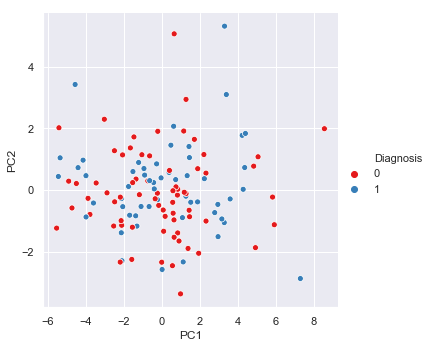

In [11]:
# Show me the PCA figure

af.showMePCAFig(DataSlice, targetCol)

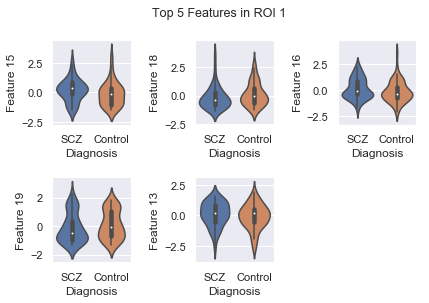

In [12]:
# Show me the top five features / ROIs as violin plots in the ROI / feature being analysed

af.showMeViolinPlts(targetCol, sigPValInds, DataSlice, 1, ROI) # When looking at ROISlices

# af.showMeViolinPlts(targetCol, sigPValInds, DataSlice, 0, feature) # When looking at featSlices


        % Accuracy  ROI Error
Region                       
3            57.83  14.059662
4            56.85  14.402378
1            56.67  15.367176
5            54.89  11.876990
6            50.32  16.339878

Mean Accuracy (across all regions) = 54.47%

Mean Error (across all regions) = 14.66%



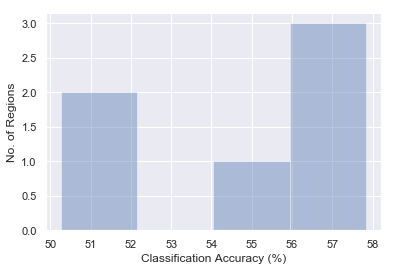

In [13]:
# Define a function, showMeROIAccPlot

dispFigs = True
    
af.showMeROIAccPlot(ROIs, tsData, indices2KeepMat, targetCol, dispFigs)

         % Accuracy  Feat Error
Feature                        
7             58.50   11.686488
13            57.96   13.258597
8             57.00   11.667905
21            56.97    9.548199
15            54.86   14.175556

Mean Accuracy (across all features) = 51.29%

Mean Error (across all features) = 9.05%



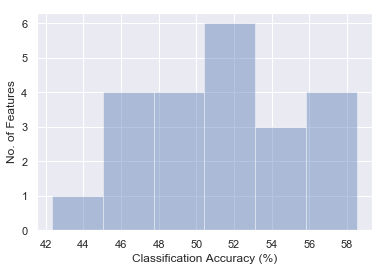

In [14]:
# Define a function, showMeFeatAccPlot
    
af.showMeFeatAccPlot(ROIs, feats, featList, subjects, tsData, indices2KeepMat, targetCol, dispFigs)

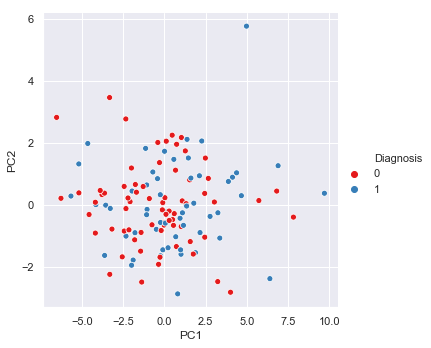

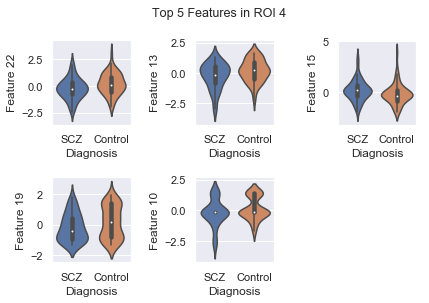


        % Accuracy  ROI Error
Region                       
3            57.83  14.059662
4            56.85  14.402378
1            56.67  15.367176
5            54.89  11.876990
6            50.32  16.339878

Mean Accuracy (across all regions) = 54.47%

Mean Error (across all regions) = 14.66%



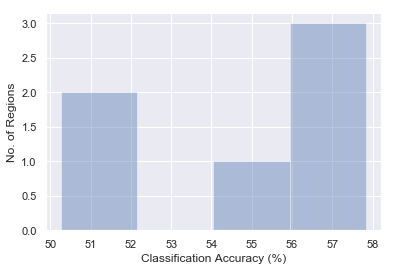

In [20]:
# Region-by-Region Analysis

af.Reg_by_Reg_Anal(ROI, tsData, targetCol, ROIs, indices2KeepMat, dispFigs)

In [16]:
# Region-by-Region Analysis
''' Input tsData
    Select a region to analyse
    Input the indices2Keep
    
    Create the targetCol
    z-score the ROISlice and ravel the targetCol
    Perform 10-fold CV '''

# Feature-by-Feature Analysis

#

' Input tsData\n    Select a region to analyse\n    Input the indices2Keep\n    \n    Create the targetCol\n    z-score the ROISlice and ravel the targetCol\n    Perform 10-fold CV '